In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit_ibm_provider import IBMProvider
# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, calc_n_mean, get_negativity_info, get_largest_connected, get_mean_cnot, filter_edges
from visualization import plot_negativities_multi, plot_cxerr_corr, plot_negativities127, plot_negativities433, plot_nmap127

provider = startup()

Account enabled


In [2]:
import networkx as nx

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]

def get_mean_cnot(graphstate, job, two_qubit_gate='cx'):
    #err_array = np.zeros(len(graphstate.edge_list))
    err_array = []
    properties = graphstate.backend.properties(datetime=job1.time_per_step()['RUNNING'])
    for edge in graphstate.edge_list:
        try:
            err = properties.gate_error(two_qubit_gate, edge)
            if err < 0.99:
                err_array.append(err)
        except:
            pass
    
    return np.mean(err_array), np.std(err_array)

### Negativity Calculation and Plotting

In [3]:
n_mean_list = []
n_std_list = []
nmit_mean_list = []
nmit_std_list = []
err_mean = []
err_std = []
device = []

In [4]:
plt.rc('font', size=12.5)

#### ibmq_lima

In [9]:
backend = provider.get_backend('ibmq_lima')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_lima (5 qubits)
Job 1 ID: 62e0854f3bc04172e4fd6c37
Job 2 ID: 62e085533bc0415ea8fd6c38


In [5]:
time0 = time()
backend = provider.get_backend('ibmq_lima')
job1 = provider.backend.retrieve_job('62e0854f3bc04172e4fd6c37')
job2 = provider.backend.retrieve_job('62e085533bc0415ea8fd6c38')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 7.03 s


{'Mean negativity': 0.3253637101290425,
 'std': 0.03203552972394254,
 'Mean negativity (mit)': 0.46169068506182925,
 'std (mit)': 0.010788159079027049,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

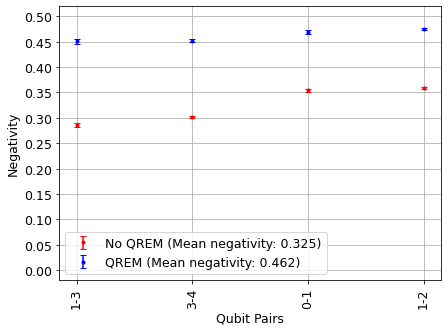

In [6]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_belem

In [15]:
backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_belem (5 qubits)
Job 1 ID: 62debd33c2d082cf7108c178
Job 2 ID: 62debd371813981decc6cb22


In [7]:
time0 = time()
backend = provider.get_backend('ibmq_belem')
job1 = provider.backend.retrieve_job('62debd33c2d082cf7108c178')
job2 = provider.backend.retrieve_job('62debd371813981decc6cb22')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.49 s


{'Mean negativity': 0.2761372590655869,
 'std': 0.024303949882431543,
 'Mean negativity (mit)': 0.41169341741067567,
 'std (mit)': 0.013987133445600018,
 'Connected N>5%': 5,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 0}

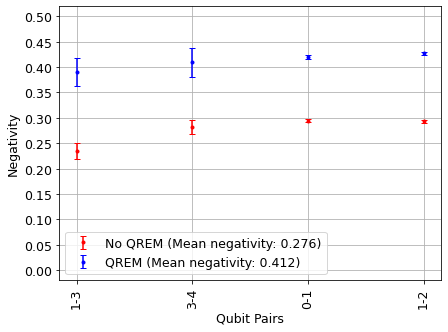

In [8]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_quito

In [5]:
backend = provider.get_backend('ibmq_quito')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_quito (5 qubits)
Job 1 ID: 62e083cc22b5f5c9d5565888
Job 2 ID: 62e083d1c2d4972bd5e36bec


In [ ]:
time0 = time()
backend = provider.get_backend('ibmq_quito')
job1 = provider.backend.retrieve_job('62e083cc22b5f5c9d5565888')
job2 = provider.backend.retrieve_job('62e083d1c2d4972bd5e36bec')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

{'Mean negativity': 0.2690744692124989,
 'std': 0.025957757034238128,
 'Mean negativity (mit)': 0.4717283057903344,
 'std (mit)': 0.004948237938112237,
 'Connected N>5%': 5,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

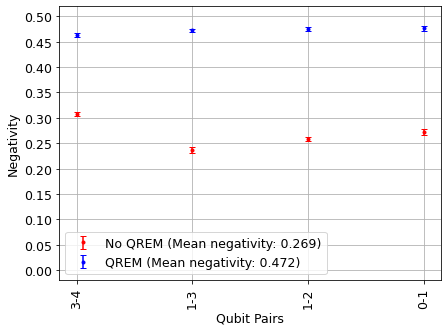

In [10]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

In [5]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords5

backend = provider.get_backend('ibmq_quito')
graphstate = GraphState(backend)

nqubits = 5

#n_mean, n_std = calc_n_mean(nmit_list)

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])

#edges = filter_edges(n_mean, threshold=0)
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(1,3),(3,4)])
print(list(nx.connected_components(G)))
#unconnected = list(set(range(nqubits)) - list(nx.connected_components(G))[0])
unconnected = set(range(nqubits))
for i in range(len(list(nx.connected_components(G)))):
    unconnected -= list(nx.connected_components(G))[i]
unconnected = list(unconnected)
print(unconnected)
qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []
#qubit_n = np.array([1,1,0,0,0])

for key in [(0,1),(1,2),(1,3),(3,4)]:
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*0.5), keep_alpha=True))
    qubit_n[key[0]] += 0.5
    qubit_n[key[1]] += 0.5

print(edge_list)
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))
        #qubit_color.append('#C0C0C0')
qubit_color[0] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
qubit_color[2] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
qubit_color[4] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
line_color[1] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
line_color[0] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
line_color[3] = mpl.colors.to_hex(cmap(0), keep_alpha=True)
fig = plot_coupling_map(nqubits, qubit_coords5, edge_list, line_color=line_color, qubit_color=qubit_color, \
                        line_width=10, figsize=(5,5))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

#ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/5q_map', dpi=300)

[{0, 1, 2, 3, 4}]
[]
[(0, 1), (1, 2), (1, 3), (3, 4)]


#### ibmq_manila

In [17]:
backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_manila (5 qubits)
Job 1 ID: 62debdad9ef0519cc8768fb4
Job 2 ID: 62debdb11813981a54c6cb2a


In [11]:
time0 = time()
backend = provider.get_backend('ibmq_manila')
job1 = provider.backend.retrieve_job('62debdad9ef0519cc8768fb4')
job2 = provider.backend.retrieve_job('62debdb11813981a54c6cb2a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.46 s


{'Mean negativity': 0.3680974256499723,
 'std': 0.02026249150100633,
 'Mean negativity (mit)': 0.4789777658340744,
 'std (mit)': 0.006402110619405756,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

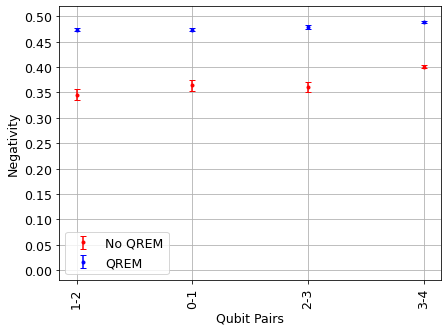

In [12]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list, print_n=False)
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_jakarta

In [15]:
backend = provider.get_backend('ibmq_jakarta')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_jakarta (7 qubits)
Job 1 ID: che9093nn76jgg0l666g
Job 2 ID: che90akrrm2uf5nf2370


In [13]:
time0 = time()
backend = provider.get_backend('ibmq_jakarta')
job1 = provider.backend.retrieve_job('che9093nn76jgg0l666g')
job2 = provider.backend.retrieve_job('che90akrrm2uf5nf2370')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.22 s


{'Mean negativity': 0.27736995662936365,
 'std': 0.032952485573451,
 'Mean negativity (mit)': 0.4684761521074656,
 'std (mit)': 0.011609854514432003,
 'Connected N>5%': 7,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 4}

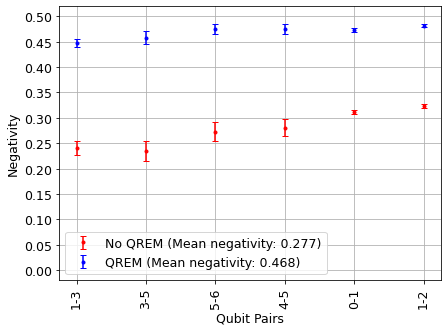

In [14]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

for i in range(len(n_list)):
    del n_list[i][(5, 6)]
for i in range(len(nmit_list)):
    del nmit_list[i][(5, 6)]
    
fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_oslo

In [10]:
backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_oslo (7 qubits)
Job 1 ID: 62e085925593a8ab36192710
Job 2 ID: 62e08599fb9fa11c75a31beb


In [15]:
time0 = time()
backend = provider.get_backend('ibm_oslo')
job1 = provider.backend.retrieve_job('62e085925593a8ab36192710')
job2 = provider.backend.retrieve_job('62e08599fb9fa11c75a31beb')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.08 s


{'Mean negativity': 0.38052011002690067,
 'std': 0.017966811390710113,
 'Mean negativity (mit)': 0.47678810264766974,
 'std (mit)': 0.01213389527943529,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

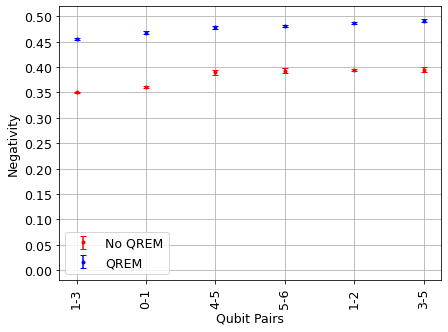

In [16]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list, print_n=False)
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_nairobi

In [58]:
backend = provider.get_backend('ibm_nairobi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_nairobi (7 qubits)
Job 1 ID: 633859475706bc52c04659b4
Job 2 ID: 6338594f5706bca0ab4659b5


In [17]:
time0 = time()
backend = provider.get_backend('ibm_nairobi')
job1 = provider.backend.retrieve_job('633859475706bc52c04659b4')
job2 = provider.backend.retrieve_job('6338594f5706bca0ab4659b5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.27 s


{'Mean negativity': 0.34769647571983403,
 'std': 0.014219340130703693,
 'Mean negativity (mit)': 0.4791458489597016,
 'std (mit)': 0.0049007106931319684,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

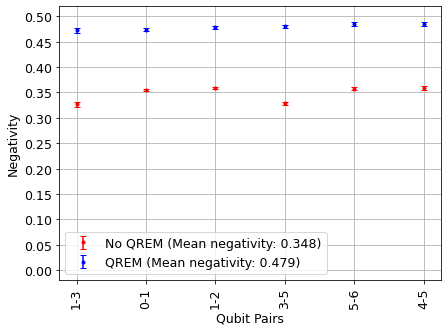

In [18]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_lagos

In [12]:
backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_lagos (7 qubits)
Job 1 ID: 62e085de3bc0414613fd6c39
Job 2 ID: 62e085e4c2d497f25fe36bee


In [19]:
time0 = time()
backend = provider.get_backend('ibm_lagos')
job1 = provider.backend.retrieve_job('62e085de3bc0414613fd6c39')
job2 = provider.backend.retrieve_job('62e085e4c2d497f25fe36bee')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.85 s


{'Mean negativity': 0.3579290428433304,
 'std': 0.025892403309026417,
 'Mean negativity (mit)': 0.45408052748002287,
 'std (mit)': 0.01122958313604215,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 3}

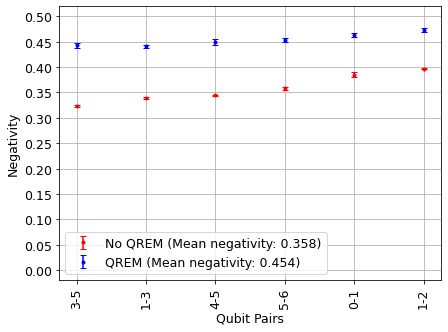

In [20]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_perth

In [13]:
backend = provider.get_backend('ibm_perth')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_perth (7 qubits)
Job 1 ID: 62e086025923b654835f3fbe
Job 2 ID: 62e086095923b634015f3fbf


In [21]:
time0 = time()
backend = provider.get_backend('ibm_perth')
job1 = provider.backend.retrieve_job('62e086025923b654835f3fbe')
job2 = provider.backend.retrieve_job('62e086095923b634015f3fbf')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.82 s


{'Mean negativity': 0.32769727380550806,
 'std': 0.01854400747547054,
 'Mean negativity (mit)': 0.46922546195560794,
 'std (mit)': 0.013258523877160542,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

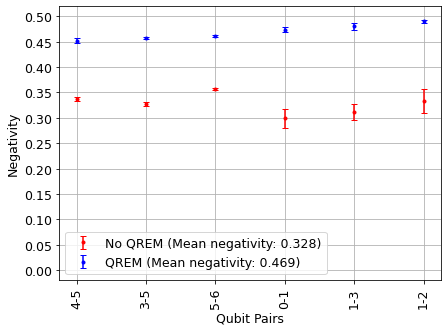

In [22]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_guadalupe

In [14]:
backend = provider.get_backend('ibmq_guadalupe')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_guadalupe (16 qubits)
Job 1 ID: 62e762a215d03377cc49967b
Job 2 ID: 62e762b922b5f5d8cd568004


In [23]:
time0 = time()
backend = provider.get_backend('ibmq_guadalupe')
job1 = provider.backend.retrieve_job('62e762a215d03377cc49967b')
job2 = provider.backend.retrieve_job('62e762b922b5f5d8cd568004')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 82.23 s


{'Mean negativity': 0.30179741101882496,
 'std': 0.026119732460266734,
 'Mean negativity (mit)': 0.4238520074096368,
 'std (mit)': 0.031777337821183686,
 'Connected N>5%': 16,
 'Connected N>50%': 16,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 16,
 'Connected N>50% (mit)': 16,
 'Connected N>75% (mit)': 16,
 'Connected N>90% (mit)': 3}

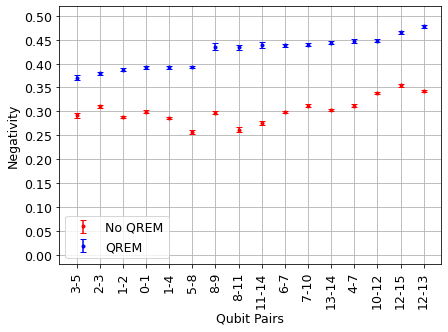

In [24]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list, print_n=False)
ax = plt.gca()
ax.legend(loc='lower left')
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_toronto

In [18]:
backend = provider.get_backend('ibmq_toronto')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_toronto (27 qubits)
Job 1 ID: 62e007f6a4cdd20758511302
Job 2 ID: 62e008097b5403fa682dcd0a


In [ ]:
time0 = time()
#backend = provider.get_backend('ibmq_toronto')
job1 = provider.backend.retrieve_job('62e007f6a4cdd20758511302')
job2 = provider.backend.retrieve_job('62e008097b5403fa682dcd0a')

#graphstate = GraphState(job1.backend())
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_geneva

In [11]:
backend = provider.get_backend('ibm_geneva')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_geneva (27 qubits)
Job 1 ID: 62e1d476fb9fa11a0da32153
Job 2 ID: 62e1d48bc12764f4277eb995


In [25]:
time0 = time()
backend = provider.get_backend('ibm_geneva')
job1 = provider.backend.retrieve_job('62e1d476fb9fa11a0da32153')
job2 = provider.backend.retrieve_job('62e1d48bc12764f4277eb995')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 187.46 s


{'Mean negativity': 0.20977691837617238,
 'std': 0.11392557413819648,
 'Mean negativity (mit)': 0.4355681045241782,
 'std (mit)': 0.10181661781865747,
 'Connected N>5%': 19,
 'Connected N>50%': 8,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 26,
 'Connected N>75% (mit)': 26,
 'Connected N>90% (mit)': 16}

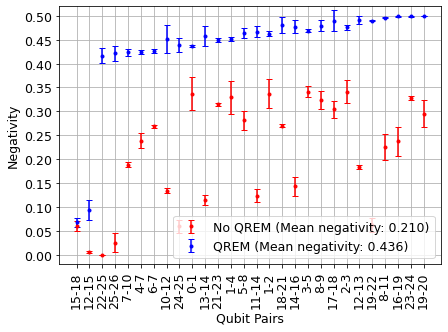

In [26]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_hanoi

In [13]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 62debb30a7255f2ce80560da
Job 2 ID: 62debb76e52ec50930ce06a5


In [27]:
time0 = time()
backend = provider.get_backend('ibm_hanoi')
job1 = provider.backend.retrieve_job('62debb30a7255f2ce80560da')
job2 = provider.backend.retrieve_job('62debb76e52ec50930ce06a5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 187.03 s


{'Mean negativity': 0.2950134496781517,
 'std': 0.07735673274927238,
 'Mean negativity (mit)': 0.44421814506462576,
 'std (mit)': 0.029110890047381155,
 'Connected N>5%': 27,
 'Connected N>50%': 12,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 7}

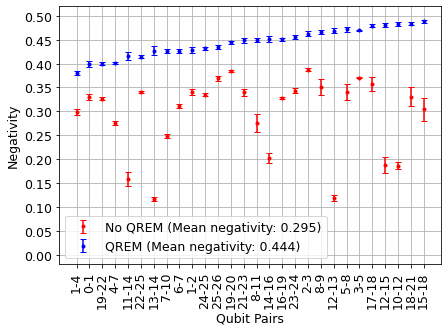

In [28]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_auckland

In [3]:
backend = provider.get_backend('ibm_auckland')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_auckland (27 qubits)
Job 1 ID: 62e0b39822b5f585165658b4
Job 2 ID: 62e0b3b2c2d497736fe36c1d


In [29]:
time0 = time()
backend = provider.get_backend('ibm_auckland')
job1 = provider.backend.retrieve_job('62e0b39822b5f585165658b4')
job2 = provider.backend.retrieve_job('62e0b3b2c2d497736fe36c1d')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 157.58 s


{'Mean negativity': 0.34828670996935784,
 'std': 0.06526265873775461,
 'Mean negativity (mit)': 0.41160042851359274,
 'std (mit)': 0.06140131182300528,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 26,
 'Connected N>75% (mit)': 20,
 'Connected N>90% (mit)': 3}

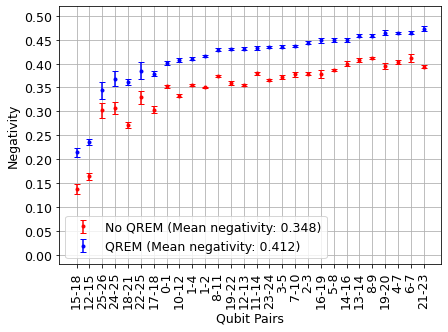

In [30]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_cairo

In [16]:
backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_cairo (27 qubits)
Job 1 ID: 62e006f6d5e93a5b6263784c
Job 2 ID: 62e007079ef051fa937697c1


In [31]:
time0 = time()
backend = provider.get_backend('ibm_cairo')
job1 = provider.backend.retrieve_job('62e006f6d5e93a5b6263784c')
job2 = provider.backend.retrieve_job('62e007079ef051fa937697c1')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 134.89 s


{'Mean negativity': 0.33508399654539556,
 'std': 0.041348855016684484,
 'Mean negativity (mit)': 0.43662632230966053,
 'std (mit)': 0.031239098478031774,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 5}

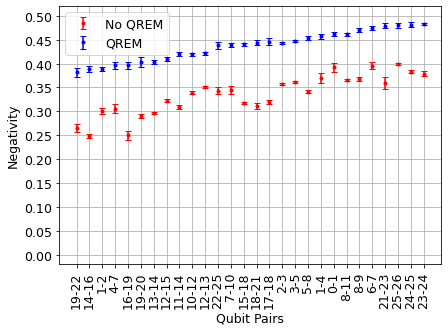

In [32]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list, print_n=False)
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)
info_dict

#### ibmq_mumbai

In [17]:
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_mumbai (27 qubits)
Job 1 ID: 62e007759ef05199917697d7
Job 2 ID: 62e0078aa7255f3449056904


In [33]:
time0 = time()
backend = provider.get_backend('ibmq_mumbai')
job1 = provider.backend.retrieve_job('62e007759ef05199917697d7')
job2 = provider.backend.retrieve_job('62e0078aa7255f3449056904')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 157.13 s


{'Mean negativity': 0.2796978908771755,
 'std': 0.08283458758254277,
 'Mean negativity (mit)': 0.4409387618189221,
 'std (mit)': 0.0825746222972075,
 'Connected N>5%': 27,
 'Connected N>50%': 21,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 24,
 'Connected N>90% (mit)': 19}

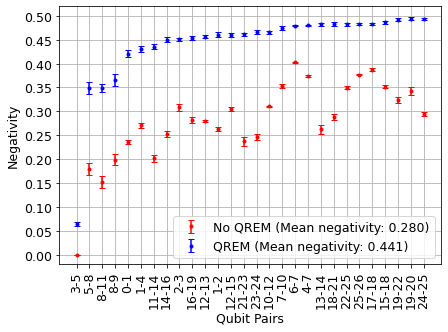

In [34]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibmq_montreal

In [ ]:
backend = provider.get_backend('ibmq_montreal')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_montreal (27 qubits)
Job 1 ID: 62e006677b5403911c2dccef
Job 2 ID: 62e0067d1813982307c6d2c3


In [ ]:
time0 = time()
backend = provider.get_backend('ibmq_montreal')
job1 = provider.backend.retrieve_job('62e006677b5403911c2dccef')
job2 = provider.backend.retrieve_job('62e0067d1813982307c6d2c3')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

Qubit 7 had an anomously high readout error 3.265e-1 (mean 4.129e-2)

#### ibmq_kolkata

In [ ]:
backend = provider.get_backend('ibmq_kolkata')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

In [35]:
time0 = time()
backend = provider.get_backend('ibmq_kolkata')
job1 = provider.backend.retrieve_job('62e0b33b5593a82bd1192732')
job2 = provider.backend.retrieve_job('62e0b3558fc097738f0a8655')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 166.96 s


{'Mean negativity': 0.3155555107567946,
 'std': 0.11961782273267371,
 'Mean negativity (mit)': 0.3898073211050471,
 'std (mit)': 0.136842968764913,
 'Connected N>5%': 27,
 'Connected N>50%': 23,
 'Connected N>75%': 8,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 24,
 'Connected N>75% (mit)': 11,
 'Connected N>90% (mit)': 11}

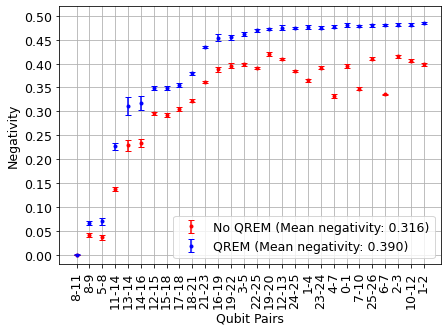

In [36]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_washington

In [3]:
backend = provider.get_backend('ibm_washington')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
#job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())

Device: ibm_washington (127 qubits)
Job 1 ID: chrg681oq2qn3r7tvvbg


In [ ]:
time0 = time()
backend = provider.get_backend('ibm_washington')
graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('chrg681oq2qn3r7tvvbg')
#job1 = provider.backend.retrieve_job('639111ce44034d30fd4d48eb') #whole device
#job2 = provider.backend.retrieve_job('6391122dd65d0d426a038369')

#job1 = provider.backend.retrieve_job('644955b572328843f2296b77')
#job2 = provider.backend.retrieve_job('64495611821d4c19b5dba25a')
#job1 = provider.backend.retrieve_job('630bf9359877ca68932a4cc7')
#job2 = provider.backend.retrieve_job('630bf9d56d08101c02db5117')
#job1 = provider.backend.retrieve_job('62f9b8033eae6d60a8d3b1ce')
#job2 = provider.backend.retrieve_job('62f9b888d7bba196db87a916')

#job1 = provider.backend.retrieve_job('62e7633bac90f75e39c85ceb') #old
#job2 = provider.backend.retrieve_job('62e763a015d033aaad49968a')

rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
#rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
#n_list2 = calc_negativities(rho_dict2, mode='max')
#nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1# + n_list2
nmit_list = nmit_list1# + nmit_list2

############# ONLY FINDS NEGATIVITY OF THE DESIRED EDGES
n_list_new = []
for i in range(len(n_list)):
    reduced_n_dict = {}
    for edge, n in n_list[i].items():
        if (edge[0] in [0,1,4,7,10,12,15,18,21,23]) and (edge[1] in [0,1,4,7,10,12,15,18,21,23]):
            reduced_n_dict[edge] = n
    n_list_new.append(reduced_n_dict)

nmit_list_new = []
for i in range(len(nmit_list)):
    reduced_n_dict = {}
    for edge, n in nmit_list[i].items():
        if (edge[0] in [0,1,4,7,10,12,15,18,21,23]) and (edge[1] in [0,1,4,7,10,12,15,18,21,23]):
            reduced_n_dict[edge] = n
    nmit_list_new.append(reduced_n_dict)
#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

fig = plot_negativities127(backend, n_list_new, nmit_list_new)

#fig.savefig('output/negativities/ibm_washington_negativities', dpi=300)

info_dict = get_negativity_info(n_list_new, nmit_list_new)
#m, s = get_mean_cnot(graphstate, job1.properties())

#n_mean_list.append(info_dict['Mean negativity'])
#n_std_list.append(info_dict['std'])
#nmit_mean_list.append(info_dict['Mean negativity (mit)'])
#nmit_std_list.append(info_dict['std (mit)'])
#err_mean.append(m)
#err_std.append(s)
#device.append(backend.name)

info_dict

#### ibm_sherbrooke

In [16]:
backend = provider.get_backend('ibm_sherbrooke')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_sherbrooke (127 qubits)
Job 1 ID: 6449e3a4492715741f309a40
Job 2 ID: 6449e409465026eec0e38585


In [39]:
time0 = time()
backend = provider.get_backend('ibm_sherbrooke')
job1 = provider.backend.retrieve_job('6449e3a4492715741f309a40')
job2 = provider.backend.retrieve_job('6449e409465026eec0e38585')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 564.08 s


In [43]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

#fig = plot_negativities127(backend, n_list, nmit_list)

#fig.savefig('output/negativities/ibm_sherbrooke_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties(), 'ecr')

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

{'Mean negativity': 0.3822575307060671,
 'std': 0.06578867063875746,
 'Mean negativity (mit)': 0.4721578889594977,
 'std (mit)': 0.022908198372106985,
 'Connected N>5%': 127,
 'Connected N>50%': 125,
 'Connected N>75%': 76,
 'Connected N>90%': 4,
 'Connected N>5% (mit)': 127,
 'Connected N>50% (mit)': 127,
 'Connected N>75% (mit)': 127,
 'Connected N>90% (mit)': 114}

#### ibm_brisbane

In [5]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_brisbane (127 qubits)
Job 1 ID: 64512bc1327c4997d4fc2a3e
Job 2 ID: 64512c256613cf3791e8afea


In [60]:
time0 = time()
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('64512bc1327c4997d4fc2a3e')
job2 = provider.backend.retrieve_job('64512c256613cf3791e8afea')

rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 572.01 s


{'Mean negativity': 0.36532142879665275,
 'std': 0.05358196948531998,
 'Mean negativity (mit)': 0.4670561537525789,
 'std (mit)': 0.04788566975353208,
 'Connected N>5%': 127,
 'Connected N>50%': 125,
 'Connected N>75%': 26,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 127,
 'Connected N>50% (mit)': 127,
 'Connected N>75% (mit)': 124,
 'Connected N>90% (mit)': 99}

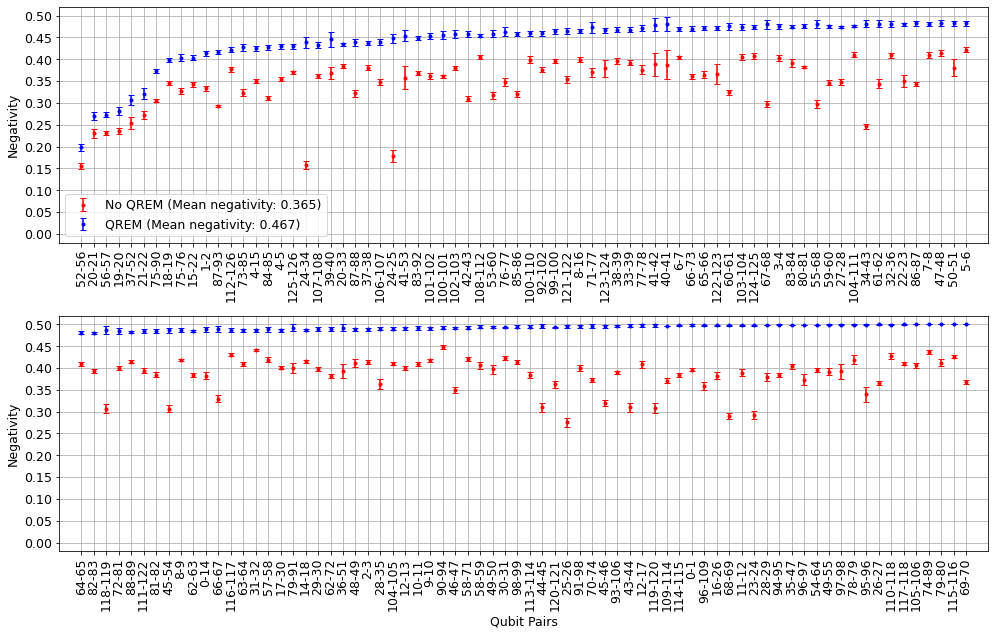

In [61]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name}_negativities', dpi=300)

fig = plot_negativities127(backend, n_list, nmit_list)

fig.savefig('output/negativities/ibm_brisbane_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties(), 'ecr')

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

info_dict

#### ibm_seattle

In [17]:
from qiskit import QuantumCircuit, execute
from qiskit import Aer

simulator = Aer.get_backend('aer_simulator')

circ = QuantumCircuit(5, 5)
qubits = [0, 1]
circ.measure(qubits, qubits)

circ.draw()

┌─┐   
q_0: ┤M├───
     └╥┘┌─┐
q_1: ─╫─┤M├
      ║ └╥┘
q_2: ─╫──╫─
      ║  ║ 
q_3: ─╫──╫─
      ║  ║ 
q_4: ─╫──╫─
      ║  ║ 
c: 5/═╩══╩═
      0  1

In [18]:
job = execute(circ, simulator)
job.result().get_counts()

{'00000': 1024}

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, execute, transpile, Aer
from qiskit.providers.aer.noise import NoiseModel

backend = provider.get_backend('ibmq_manila')
state = QuantumCircuit(5,5)
state.h([0,1])
state.cp(np.pi/2, 0,1)
#cr = ClassicalRegister(2)
#state.add_register(cr)
#state.measure([0,1],cr)
#state.measure_all()
state.measure([0,3,4],[0,3,4])
display(state.draw())
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

backend = Aer.get_backend('aer_simulator')
job = execute(state, backend=backend,
              coupling_map=coupling_map,
              basis_gates=basis_gates,
              noise_model=noise_model,
              shots=10000)
result = job.result()
print(result.get_counts())
#circ = transpile(state, backend = backend)
#job = backend.run(circ, shots = 8192)

#job = execute(circ, backend = backend, shots = 8192)

┌───┐         ┌─┐
q_0: ┤ H ├─■───────┤M├
     ├───┤ │P(π/2) └╥┘
q_1: ┤ H ├─■────────╫─
     └───┘          ║ 
q_2: ───────────────╫─
      ┌─┐           ║ 
q_3: ─┤M├───────────╫─
      └╥┘    ┌─┐    ║ 
q_4: ──╫─────┤M├────╫─
       ║     └╥┘    ║ 
c: 5/══╩══════╩═════╩═
       3      4     0

{'11001': 1, '10001': 87, '01000': 142, '00000': 4729, '11000': 1, '01001': 147, '10000': 87, '00001': 4806}


In [14]:
backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)
graphstate.gen_qrem_circuits()
print(graphstate.nqubits)
print(graphstate.qubits)

433
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,

In [3]:
backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)
shots = 2000
#shots=8192
job1 = graphstate.run_qst(reps=4, shots=shots, qrem=True, execute_only=True)
#job2 = graphstate.run_qst(reps=4, shots=shots, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())

Device: ibm_seattle (433 qubits)
Job 1 ID: cimjvojc243ejrja9am0


In [3]:
time0 = time()
backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)
#job1 = provider.backend.retrieve_job('chdjcp1cf94mmsdrnugg')
#job1 = provider.backend.retrieve_job('chhj5fmo5i9gdbcrufd0')
#job1 = provider.backend.retrieve_job('chmpukdnopt07g4e1de0')
#job1 = provider.backend.retrieve_job('chqmh9taqbbvbu0svpv0')
#job1 = provider.backend.retrieve_job('chvf7b0pd9tm50s1k16g')
#job1 = provider.backend.retrieve_job('ci3tpkokbvp2ovoqk6dg')
job1 = provider.backend.retrieve_job('ci8gqae3instr52eapgg')
#job1 = provider.backend.retrieve_job('cidsf4k60l54kv81l740')
#job1 = provider.backend.retrieve_job('ciif4vju5mrpmcet4le0')
#job1 = provider.backend.retrieve_job('cimjvojc243ejrja9am0')
#job2 = provider.backend.retrieve_job('')

rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
#rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 249.79 s


In [ ]:
backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)
graphstate.gen_qst_circuits()

In [4]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
#n_list2 = calc_negativities(rho_dict2, mode='max')
#nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 #+ n_list2
nmit_list = nmit_list1 #+ nmit_list2

In [74]:
a = []
b = []
for trial in n_list:
    a.append(trial[(383, 384)])
for trial in nmit_list:
    b.append(trial[(383, 384)])
print(a)
print(b)
print(np.mean(b)-np.mean(a))

[0.014855591336132897, 0.010221381139623188, 0.01809953240173816, 0.016469028128981593]
[0.44638999874513074, 0.49632488744319436, 0.4572866389056285, 0.45457373415213065]
0.4487324315599021


Plot negativity vs pairs and correlations

In [5]:
import csv
readout_errors_dict = {}

#fp = open('jobs_id_lagos_hahn_echo_full','r')
fp = open('ibm_seattle_calibrations_2023-06-20T14_30_20Z.csv','r')
reader = csv.reader(fp, delimiter=',')
row_count = 0
for row in reader:
    if row_count > 0:
        readout_errors_dict[int(row[0])] = float(row[5])
    row_count += 1
fp.close()
print(readout_errors_dict)

{0: 0.1202, 1: 0.0227, 2: 0.0241, 3: 0.2562, 4: 0.0206, 5: 0.0117, 6: 0.0167, 7: 0.0282, 8: 0.1291, 9: 0.2463, 10: 0.0318, 11: 0.0222, 12: 0.017, 13: 0.0129, 14: 0.095, 15: 0.253333333, 16: 0.0166, 17: 0.051666667, 18: 0.215, 19: 0.0279, 20: 0.13, 21: 0.0228, 22: 0.0772, 23: 0.0462, 24: 0.201666667, 25: 0.0582, 26: 0.0153, 27: 0.0163, 28: 0.0637, 29: 0.151666667, 30: 0.0163, 31: 0.121666667, 32: 0.086666667, 33: 0.0154, 34: 0.029, 35: 0.0178, 36: 0.186, 37: 0.1042, 38: 0.198333333, 39: 0.153333333, 40: 0.0305, 41: 0.0327, 42: 0.0784, 43: 0.0583, 44: 0.3009, 45: 0.061666667, 46: 0.2366, 47: 0.2268, 48: 0.1222, 49: 0.0558, 50: 0.0768, 51: 0.046666667, 52: 0.1188, 53: 0.025, 54: 0.185, 55: 0.091666667, 56: 0.0842, 57: 0.0257, 58: 0.0565, 59: 0.0097, 60: 0.012, 61: 0.0186, 62: 0.0502, 63: 0.1696, 64: 0.08, 65: 0.195, 66: 0.019, 67: 0.0288, 68: 0.0142, 69: 0.0158, 70: 0.0158, 71: 0.0309, 72: 0.0751, 73: 0.1264, 74: 0.2104, 75: 0.1609, 76: 0.2285, 77: 0.0144, 78: 0.0247, 79: 0.0146, 80: 0.01

{'Mean negativity': 0.1146021597082603,
 'std': 0.09887022941887093,
 'Mean negativity (mit)': 0.3403268477971081,
 'std (mit)': 0.1179415085115371,
 'Connected N>5%': 184,
 'Connected N>50%': 11,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 413,
 'Connected N>50% (mit)': 330,
 'Connected N>75% (mit)': 37,
 'Connected N>90% (mit)': 11}

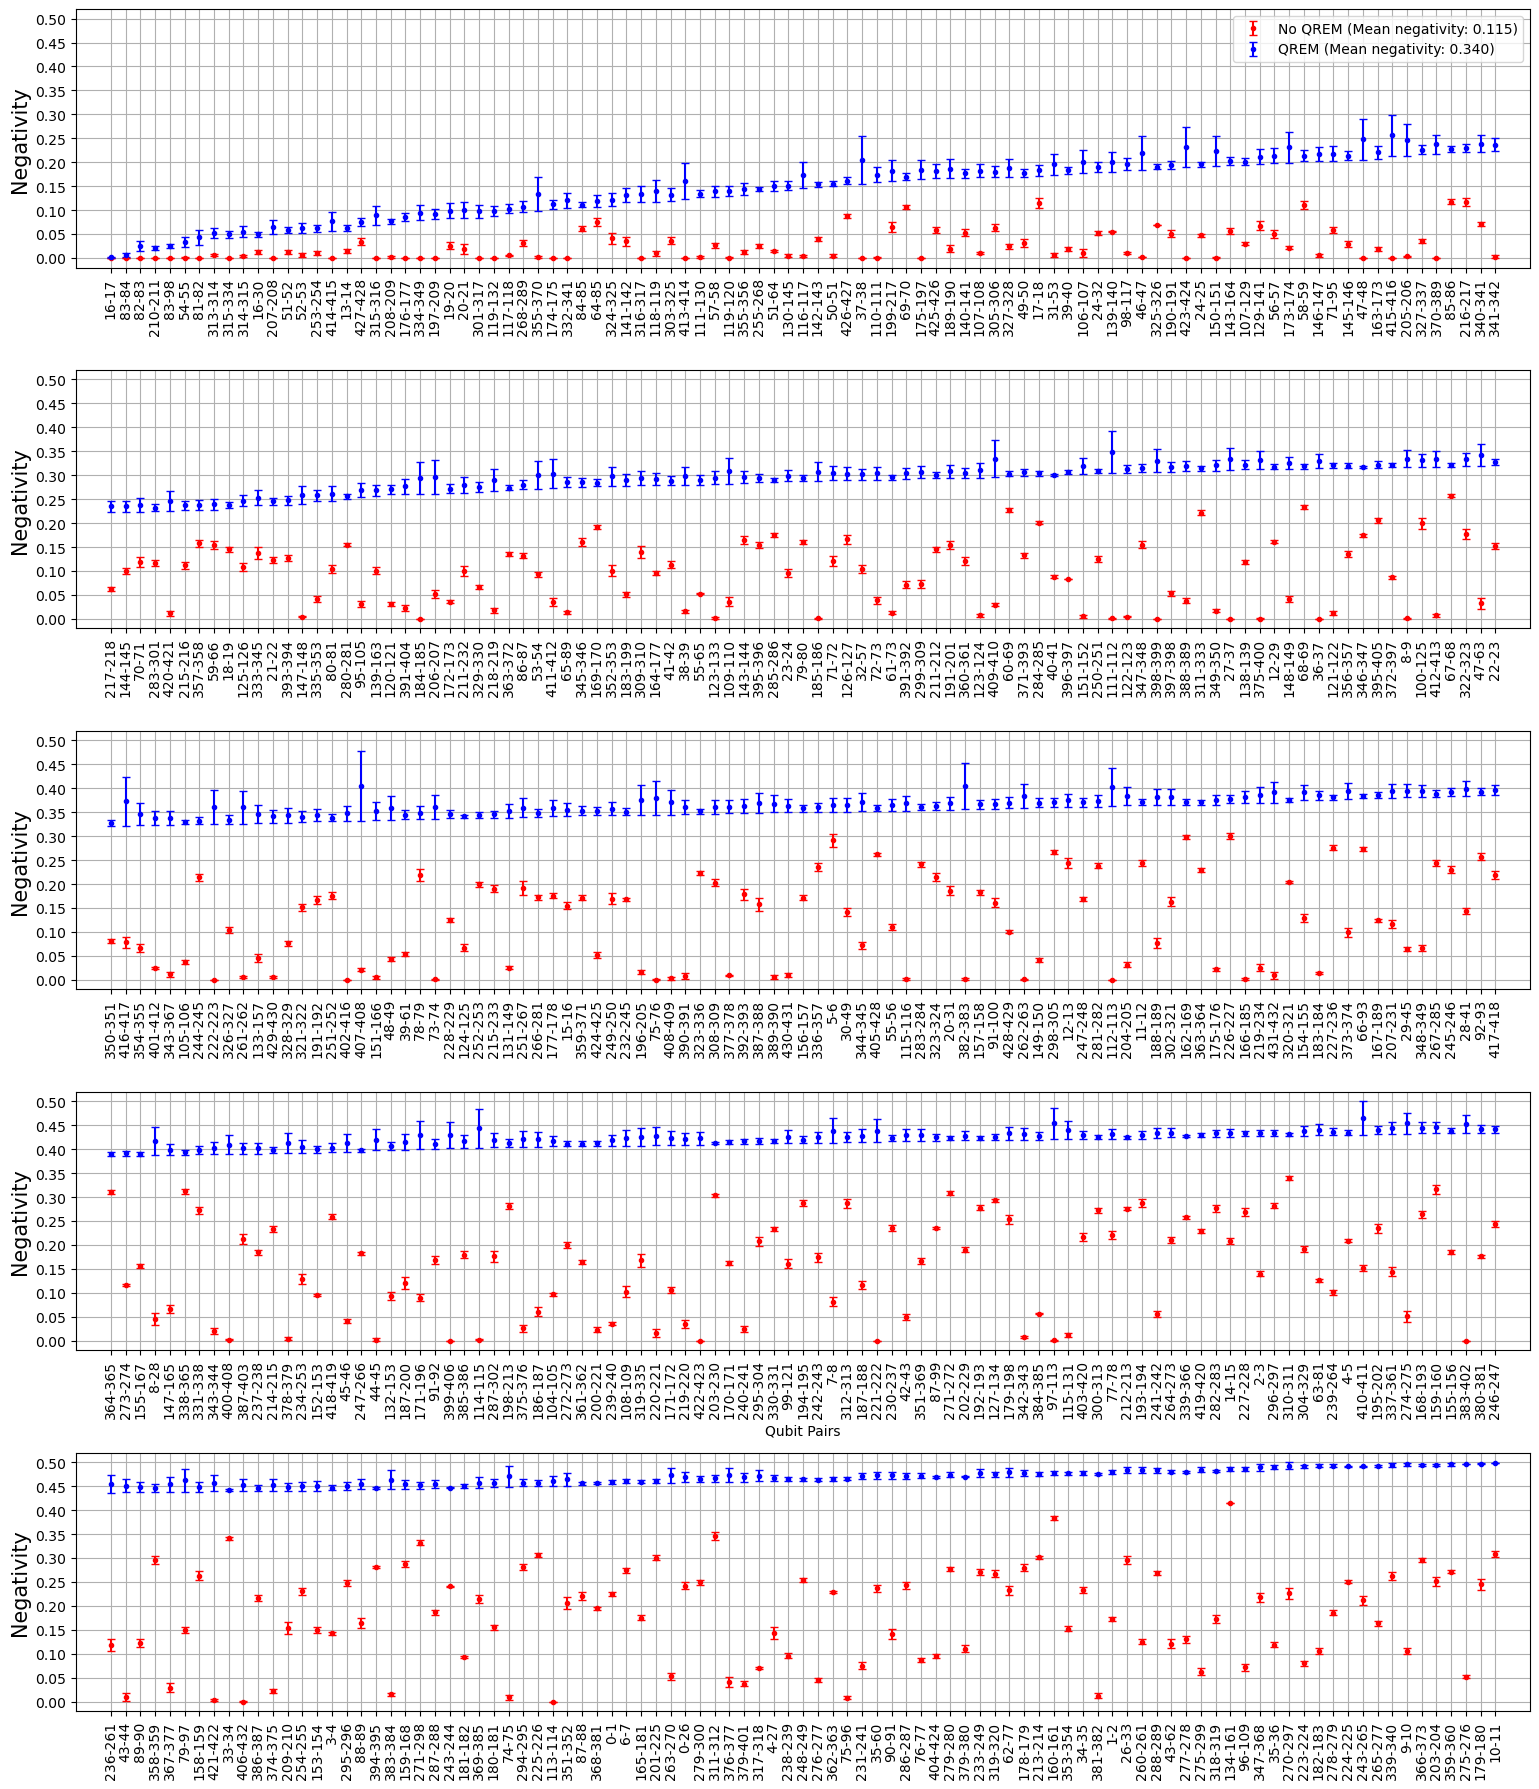

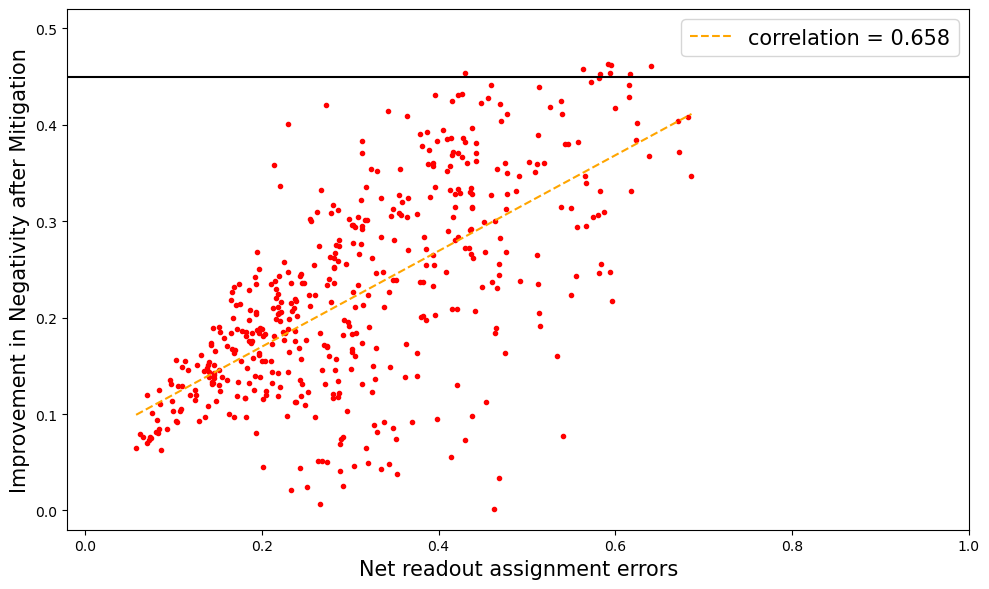

In [20]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr

#fig, fig2 = plot_negativities433(backend, graphstate.adj_qubits, readout_errors_dict, n_list, nmit_list)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(15.5,18))

fig2, scatter_plot = plt.subplots(figsize = (10,6))
# Extract the mean negativity and its standard deviation
try:
    n_list[0]
except:
    n_list = [n_list]
    nmit_list = [nmit_list]
edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)
nmit_mean, nmit_std = calc_n_mean(nmit_list)
    
# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
    
#
errors_dict = {}
#errors_std_dict = {}
for edge in edges:
    connected_qubits = graphstate.adj_qubits[edge].copy()
    connected_qubits.append(list(edge)[0])
    connected_qubits.append(list(edge)[1])
    errors = []
    for qubit in connected_qubits:
        errors.append(readout_errors_dict[qubit])
    errors_dict[edge] = 1 - np.prod(np.ones(len(errors))-errors)
    #errors_std_dict[edge] = np.std(errors)/np.sqrt(len(connected_qubits))
        
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)*2
    
Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)*2
    
read_errors = np.fromiter(errors_dict.values(), float)
#read_errors_err = np.fromiter(errors_std_dict.values(), float)
# Order in increasing minimum negativity (QREM)
    
Y1min = Y1 - Y1err

idx = Y1min.argsort()
X = X[idx]
Y1 = Y1[idx]
Y1err = Y1err[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]
read_errors = read_errors[idx]
#read_errors_err = read_errors_err[idx]

qp = int(len(X)/5)
    
ax1.errorbar(X[:qp], Y0[:qp], yerr=Y0err[:qp], capsize=3, fmt='.', c='r', 
             label=f'No QREM (Mean negativity: {np.mean(Y0):.3f})')
    
ax1.errorbar(X[:qp], Y1[:qp], yerr=Y1err[:qp], capsize=3, fmt='.', c='b', 
             label=f'QREM (Mean negativity: {np.mean(Y1):.3f})')

ax2.errorbar(X[qp:qp*2], Y0[qp:qp*2], yerr=Y0err[qp:qp*2], capsize=3, fmt='.', c='r', 
             label=f'No QREM (Mean negativity: {np.mean(Y0):.3f})')
    
ax2.errorbar(X[qp:qp*2], Y1[qp:qp*2], yerr=Y1err[qp:qp*2], capsize=3, fmt='.', c='b', 
             label=f'QREM (Mean negativity: {np.mean(Y1):.3f})')

ax3.errorbar(X[qp*2:qp*3], Y0[qp*2:qp*3], yerr=Y0err[qp*2:qp*3], capsize=3, fmt='.', c='r', 
             label=f'No QREM (Mean negativity: {np.mean(Y0):.3f})')
    
ax3.errorbar(X[qp*2:qp*3], Y1[qp*2:qp*3], yerr=Y1err[qp*2:qp*3], capsize=3, fmt='.', c='b', 
             label=f'QREM (Mean negativity: {np.mean(Y1):.3f})')

ax4.errorbar(X[qp*3:qp*4], Y0[qp*3:qp*4], yerr=Y0err[qp*3:qp*4], capsize=3, fmt='.', c='r', 
             label=f'No QREM (Mean negativity: {np.mean(Y0):.3f})')
    
ax4.errorbar(X[qp*3:qp*4], Y1[qp*3:qp*4], yerr=Y1err[qp*3:qp*4], capsize=3, fmt='.', c='b', 
             label=f'QREM (Mean negativity: {np.mean(Y1):.3f})')

ax5.errorbar(X[qp*4:qp*5], Y0[qp*4:qp*5], yerr=Y0err[qp*4:qp*5], capsize=3, fmt='.', c='r', 
             label=f'No QREM (Mean negativity: {np.mean(Y0):.3f})')
    
ax5.errorbar(X[qp*4:qp*5], Y1[qp*4:qp*5], yerr=Y1err[qp*4:qp*5], capsize=3, fmt='.', c='b', 
             label=f'QREM (Mean negativity: {np.mean(Y1):.3f})')

for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.set_ylim([-0.02, 0.52])
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity", fontsize=15)
    ax.margins(0.025, 0.05)
    
mitigation_size = Y1 - Y0
scatter_plot.scatter(read_errors, mitigation_size, c='r', marker = '.')

c, m = polyfit(read_errors, mitigation_size, 1)
Xfit = np.linspace(min(read_errors), max(read_errors), 100)
correlation,_ = pearsonr(read_errors, mitigation_size)
scatter_plot.plot(Xfit, m*Xfit+c, ls='--', color = 'orange', label=f'correlation = {correlation:.3f}')
#scatter_plot.set_yticks(np.arange(0, 0.55, 0.05))
scatter_plot.set_ylim([-0.02, 0.52])
#scatter_plot.set_xticks(np.arange(0, 1, 0.05))
scatter_plot.set_xlim([-0.02, 1])
scatter_plot.set_ylabel("Improvement in Negativity after Mitigation", fontsize=15)
scatter_plot.set_xlabel('Net readout assignment errors', fontsize=15)
scatter_plot.margins(0.025, 0.05)
#scatter_plot.set_xticks(fontsize = 15)
scatter_plot.axhline(y=0.45,color='black', linestyle='-')
ax1.legend()
scatter_plot.legend(prop={'size':15})
ax4.set_xlabel("Qubit Pairs")
#ax1.set_title(backend.name)
fig.set_tight_layout(True)
fig2.set_tight_layout(True)

fig.savefig('output/433q_BellState_negativity_2023_6_20', dpi=300)
fig2.savefig('output/433q_BellState_correlations_2023_6_20', dpi=300)
info_dict = get_negativity_info(n_list, nmit_list)
info_dict

In [ ]:
m, s = get_mean_cnot(graphstate, job1.properties(), 'ecr')
n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name)

get negativity raw data from csv

In [17]:
import csv

backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)

n_mean = {}

fp = open('output/neg_qrem_2023_7_12.csv','r')
reader = csv.reader(fp, delimiter=',')
line_count = 0
for row in reader:
    #print(row)
    operator_x, operator_z = row[0].split(',')
    n_mean[(int(operator_x[1:]), int(operator_z[0:-1]))] = np.mean([float(x) for x in row[1:]])
    line_count += 1
fp.close()
print(n_mean)

{(0, 1): 0.43378104028389297, (0, 26): 0.4558356467843002, (1, 2): 0.47093465594734385, (2, 3): 0.43654899466089386, (3, 4): 0.43329646465240096, (4, 5): 0.4166154022012556, (4, 27): 0.12973261142623657, (5, 6): 0.3406142075577976, (6, 7): 0.447648179097993, (7, 8): 0.4145044892174728, (8, 9): 0.31429692914145413, (8, 28): 0.36876921054082046, (9, 10): 0.4790385088239087, (10, 11): 0.4989527794392528, (11, 12): 0.40486303648886035, (12, 13): 0.41413803449440484, (12, 29): 0.42362731813706933, (13, 14): 0.21277373952058615, (14, 15): 0.44418931003695705, (15, 16): 0.11449788353366763, (16, 17): 0.1313296411765233, (16, 30): 0.1986069034368727, (17, 18): 0.17515140754612163, (18, 19): 0.22162559866785156, (19, 20): 0.12577630731266354, (20, 21): 0.13265185734532764, (20, 31): 0.3434090837245301, (21, 22): 0.2497345259471409, (22, 23): 0.3161602668202711, (23, 24): 0.3105359358385459, (24, 25): 0.21016004424529036, (24, 32): 0.16285773265652276, (26, 33): 0.47354962932421196, (27, 37): 0.

Plot/Save Negativity Map

In [22]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords433

nqubits = 433

n_mean, n_std = calc_n_mean(nmit_list)

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])

edges = filter_edges(n_mean, threshold=0)
G = nx.Graph()
G.add_edges_from(edges)
print(list(nx.connected_components(G)))
#unconnected = list(set(range(nqubits)) - list(nx.connected_components(G))[0])
unconnected = set(range(nqubits))
for i in range(len(list(nx.connected_components(G)))):
    unconnected -= list(nx.connected_components(G))[i]
unconnected = list(unconnected)

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_mean.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values

print(edge_list)
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords433, edge_list, line_color=line_color, qubit_color=qubit_color, \
                        line_width=6, figsize=(20,20))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

#ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
cb.set_label(label = 'Negativity', size=30)
cb.ax.tick_params(labelsize=20)
fig.savefig('output/ghznmap433qrem_2023_6_20.png', dpi=400)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 22

In [5]:
mpl.colors.to_hex(cmap(2*0), keep_alpha=True)

'#ff0000ff'

In [8]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords433

nqubits = 433
backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend)
graphstate.gen_qst_circuits()
#n_mean, n_std = calc_n_mean(nmit_list)

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'g', 'b'])

#edges = filter_edges(n_mean, threshold=0)
edges = graphstate.edge_list
G = nx.Graph()
G.add_edges_from(edges)
print(list(nx.connected_components(G)))
#unconnected = list(set(range(nqubits)) - list(nx.connected_components(G))[0])
unconnected = set(range(nqubits))
for i in range(len(list(nx.connected_components(G)))):
    unconnected -= list(nx.connected_components(G))[i]
unconnected = list(unconnected)

qubit_color = []
edge_list = []
line_color = []

layers = []
while edges:
    connected_qubits = []  # Qubits already connected in the current time step
    #connected_edges = []
    remove = []
    for edge in edges:
        if np.any(np.isin(edge, connected_qubits)) == False:
            connected_qubits.extend(edge)
            remove.append(edge)
    # Remove connected edges from unconnected edges list
    for edge in remove:
        edges.remove(edge)
    layers.append(remove)
print(layers)

for i in range(len(layers)):
    for key in layers[i]:
        edge_list.append(key)
        if i == 0:
            line_color.append('#0343DF')
        elif i == 1:
            line_color.append('#15B01A')
        else:
            line_color.append('#E50000')

print(edge_list)
for i, n in enumerate(np.zeros(433)):
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append('#E6DAA6')

fig = plot_coupling_map(nqubits, qubit_coords433, edge_list, line_color=line_color, qubit_color=qubit_color, \
                        line_width=6, figsize=(20,20))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

#ax = fig.get_axes()[0]
#cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

#im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
#fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')

fig.savefig('output/433q_map.png', dpi=400)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 22

In [52]:
n_mean, n_std = calc_n_mean(n_list)
nmit_mean, nmit_std = calc_n_mean(nmit_list)

In [53]:
print(n_list)
print(n_mean)
print(nmit_mean)

[{(0, 1): 0.22127741019930125, (0, 26): 0.24671330830589933, (1, 2): 0.17001192027844625, (2, 3): 0.13795195384687903, (3, 4): 0.14725796901864763, (4, 5): 0.20506621462726585, (4, 27): 0.14922356346419338, (5, 6): 0.2756590432533199, (6, 7): 0.2661486404811181, (7, 8): 0.06695776149857413, (8, 9): 0.003981683043341998, (8, 28): 0.062219506348861184, (9, 10): 0.09968584973802977, (10, 11): 0.31432520512988027, (11, 12): 0.25246543597474963, (12, 13): 0.257935534172101, (12, 29): 0.1613484250339224, (13, 14): 0.01958452587017521, (14, 15): 0.20755716966098822, (15, 16): 0.1646886662337343, (16, 17): 0.0, (16, 30): 0.009635630598981936, (17, 18): 0.11713669654110412, (18, 19): 0.1445210424586002, (19, 20): 0.026405657248350697, (20, 21): 0.01325147390367441, (20, 31): 0.18017523565703367, (21, 22): 0.12889443963553762, (22, 23): 0.1503715228232748, (23, 24): 0.1027418611560475, (24, 25): 0.04554326577967499, (24, 32): 0.04793794640643155, (26, 33): 0.3020340566010672, (27, 37): 0.0, (28,

#### Export Negativities

In [54]:
n_dicts = dict.fromkeys(n_mean)
for k, v in n_dicts.items():
    n_dicts[k] = []
    
for i in range(len(n_list)):
    for k in n_dicts.keys():
        #print(k)
        n_dicts[k].append(n_list[i][k])

In [55]:
nmit_dicts = dict.fromkeys(nmit_mean)
for k, v in nmit_dicts.items():
    nmit_dicts[k] = []
    
for i in range(len(nmit_list)):
    for k in nmit_dicts.keys():
        #print(k)
        nmit_dicts[k].append(nmit_list[i][k])

In [56]:
import csv

with open('output/neg_2023_6_20.csv', 'w', newline='') as f:
    w = csv.writer(f)
    for k, v in n_dicts.items():
        w.writerow([k] + v)
        
with open('output/neg_qrem_2023_6_20.csv', 'w', newline='') as f:
    w = csv.writer(f)
    for k, v in nmit_dicts.items():
        w.writerow([k] + v)

#### Negativity Map

In [6]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

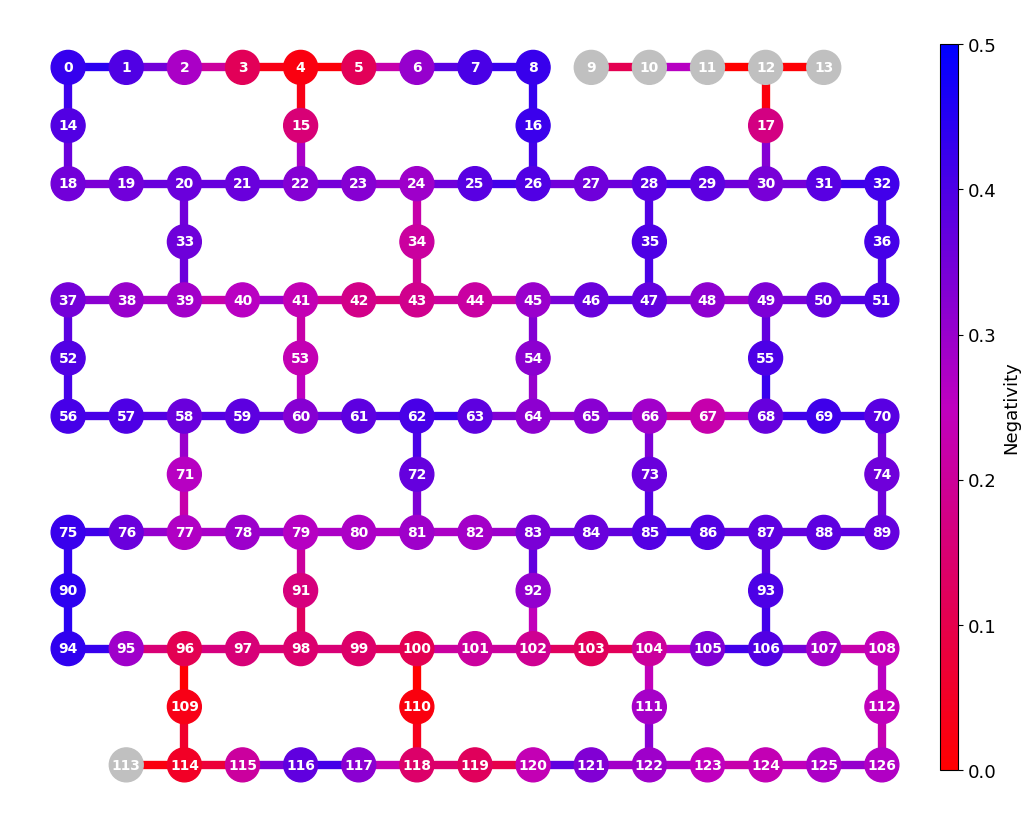

In [7]:
plot_nmap127(graphstate, n_list)

In [23]:
nqubits = 127
#n_dict = nmit_mean
n_dict = calc_n_mean(n_list)

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmap127.png', dpi=400)

fig

AttributeError: 'tuple' object has no attribute 'items'

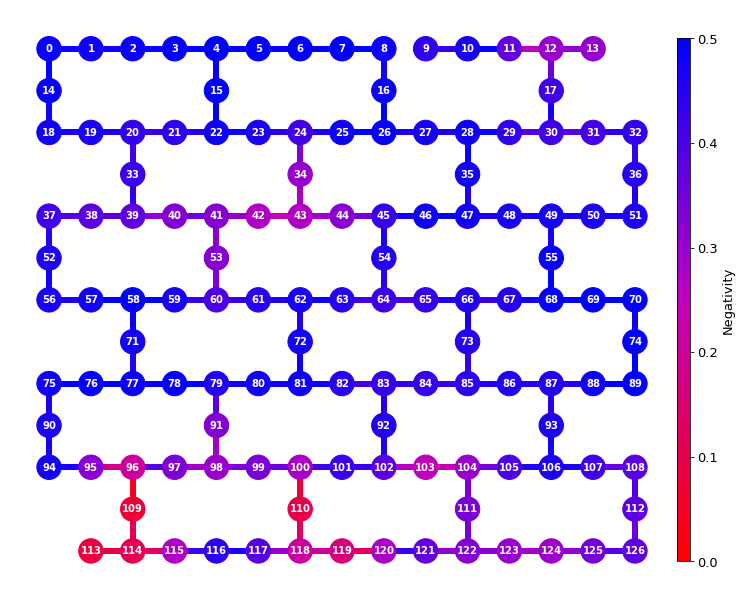

In [61]:
nqubits = 127
n_dict = nmit_mean
#n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmitmap127.png', dpi=400)

fig

#### 433 Test

In [13]:
import rustworkx as rx
import math

In [14]:
backend = provider.get_backend('ibm_seattle')
coupling_map = backend.coupling_map
config = backend.configuration()

In [15]:
num_qubits = config.n_qubits

# Replace with planar_layout() when rustworkx offers it
qubit_coordinates_rx = rx.spring_layout(coupling_map.graph, seed=1234)
scaling_factor = 10 ** int(math.log10(num_qubits) + 1)
qubit_coordinates = [
    (
        int(scaling_factor * qubit_coordinates_rx[i][0]),
        int(scaling_factor * qubit_coordinates_rx[i][1]),
    )
    for i in range(num_qubits)
]

if any(x[0] < 0 or x[1] < 0 for x in qubit_coordinates):
    min_entry = min(qubit_coordinates, key=lambda x: min(x[0], x[1]))
    negative_offset = 0 - min(min_entry)
    qubit_coordinates = [
        (x[0] + negative_offset, x[1] + negative_offset) for x in qubit_coordinates
    ]

In [16]:
#qubit_coordinates

from qiskit.visualization import plot_gate_map, plot_coupling_map, plot_error_map

In [17]:
coupling_map

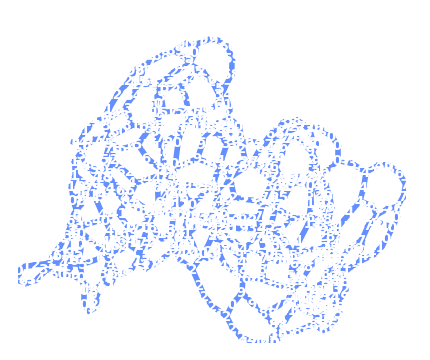

In [18]:
plot_coupling_map(num_qubits=num_qubits, coupling_map=coupling_map.get_edges(), qubit_coordinates=qubit_coordinates)

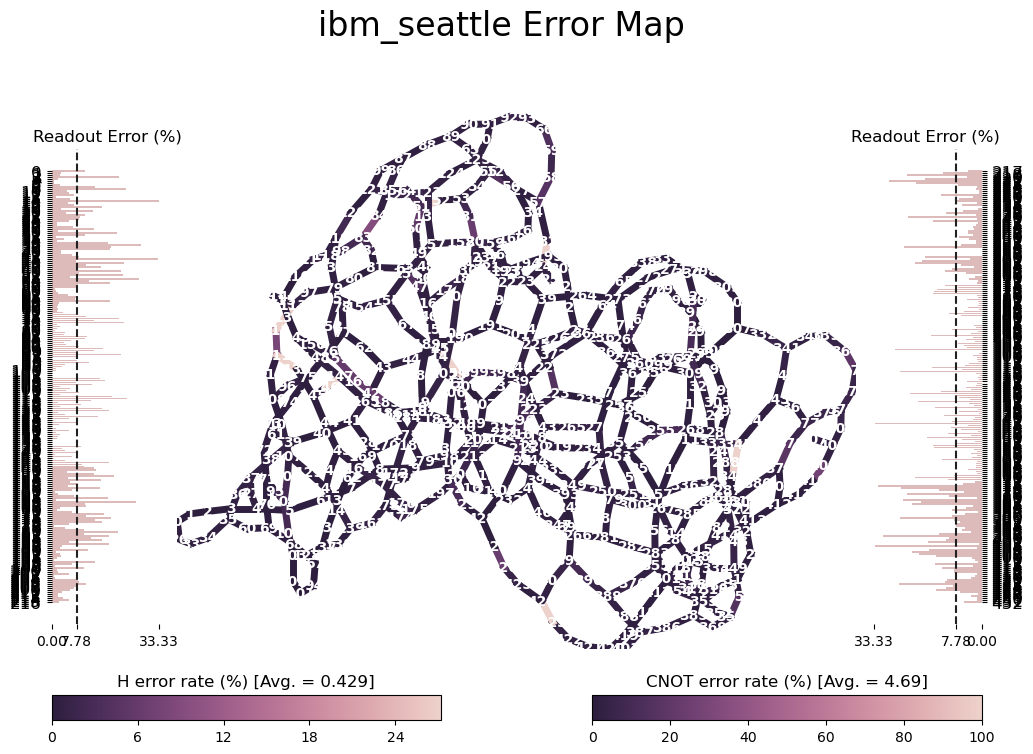

In [19]:
plot_error_map(backend)

In [20]:
qubit_coordinates_map433 = []

even = [2, 6, 10, 14, 18, 22, 26]
odd = [0, 4, 8, 12, 16, 20, 24]

for i in range(26):
    qubit_coordinates_map433.append([0, i])
for i in range(1, 12):
    #print(i)
    if (i % 2) == 0:
        for k in even:
            qubit_coordinates_map433.append([i*2-1, k])
    else:
        for k in odd:
            qubit_coordinates_map433.append([i*2-1, k])
    for k in range(27):
        qubit_coordinates_map433.append([i*2, k])
        
for k in even:
    qubit_coordinates_map433.append([23, k])
    
for i in range(1, 27):
    qubit_coordinates_map433.append([24, i])

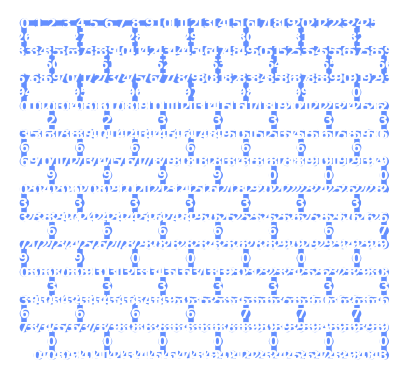

In [21]:
plot_coupling_map(num_qubits=num_qubits, coupling_map=coupling_map.get_edges(), qubit_coordinates=qubit_coordinates_map433)

In [25]:
print(job1.time_per_step())

{'created': datetime.datetime(2023, 5, 10, 16, 15, 0, 639518, tzinfo=tzlocal()), 'finished': datetime.datetime(2023, 5, 10, 16, 45, 23, 844569, tzinfo=tzlocal()), 'running': datetime.datetime(2023, 5, 10, 16, 15, 5, 13458, tzinfo=tzlocal())}


## Negativity Correlations

In [33]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr


n_mean = calc_n_mean(n_list)
nmit_mean = calc_n_mean(nmit_list)
properties = backend.properties(datetime=job1.time_per_step()['running'])
adj_edges = graphstate.adj_edges

n_meanf = {}
nmit_meanf = {}
edges = n_mean[0].keys()
for edge in edges:
    err = properties.gate_error('ecr', edge)
    if err < 0.1:
        n_meanf[edge] = n_mean[0][edge]
        nmit_meanf[edge] = nmit_mean[0][edge]

#fig1a = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
X, Y0 = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=True)
#fig2a = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
X, Y1 = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=True)

c0, m0 = polyfit(X, Y0, 1)
c1, m1 = polyfit(X, Y1, 1)
Xfit = np.linspace(min(X), max(X), 100)

corr0, _ = pearsonr(X, Y0)
corr1, _ = pearsonr(X, Y1)

BackendPropertyError: 'Could not find the desired property for ecr'

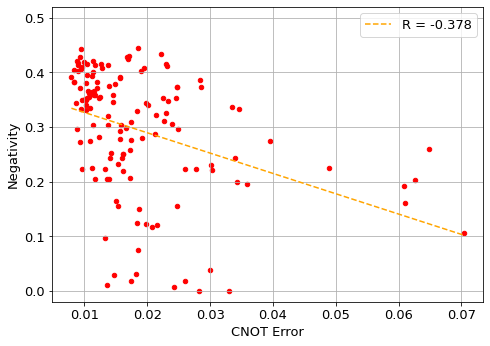

In [47]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y0, color='red', s=20)
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'R = {corr0:.3f}')

#ax.set_title('No QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)
ax.set_ylim(-0.02, 0.52)
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation1', dpi=300)

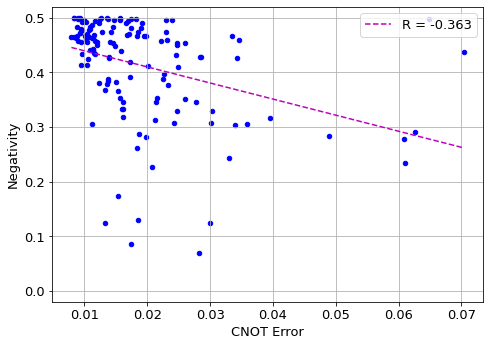

In [48]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y1, color='b', s=20)
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'R = {corr1:.3f}')

#ax.set_title('QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)
ax.set_ylim(-0.02, 0.52)
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation2', dpi=300)

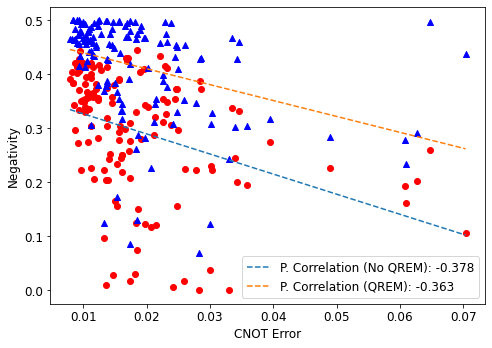

In [18]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y0, marker='o', color='r')
ax.plot(Xfit, m0*Xfit+c0, ls='--', label=f'P. Correlation (No QREM): {corr0:.3f}')
ax.scatter(X, Y1, marker='^', color='b')
ax.plot(Xfit, m1*Xfit+c1, ls='--', label=f'P. Correlation (QREM): {corr1:.3f}')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend()
#ax.legend(loc=1)

fig.set_tight_layout(True)
#fig.savefig('output/negativitycorrelation', dpi=300)

In [62]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
import numpy as np

c0, m0 = polyfit(err_mean, n_mean_list, 1)
c1, m1 = polyfit(err_mean, nmit_mean_list, 1)
Xfit = np.linspace(min(err_mean), max(err_mean), 100)

corr0, _ = pearsonr(err_mean, n_mean_list)
corr1, _ = pearsonr(err_mean, nmit_mean_list)

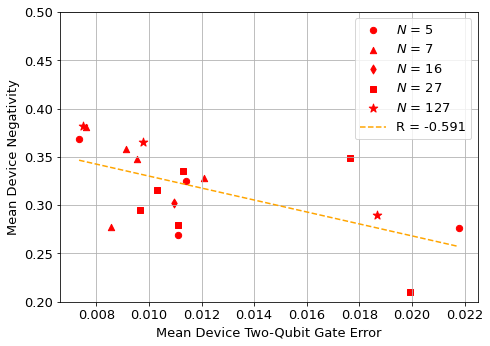

In [81]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(7, 5))
s = 40
ax.scatter(err_mean[:4], n_mean_list[:4], marker='o', color='r', s=s, label='$\it{N}$ = 5')
ax.scatter(err_mean[4:9], n_mean_list[4:9], marker='^', color='r', s=s, label='$\it{N}$ = 7')
ax.scatter(err_mean[9], n_mean_list[9], marker='d', color='r', s=s, label='$\it{N}$ = 16')
ax.scatter(err_mean[10:16], n_mean_list[10:16], marker='s', color='r', s=s, label='$\it{N}$ = 27')
ax.scatter(err_mean[16:19], n_mean_list[16:19], marker='*', color='r', s=s*2, label='$\it{N}$ = 127')
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'R = {corr0:.3f}')

ax.set_ylim(0.2, 0.5)

ax.set_ylabel('Mean Device Negativity')
ax.set_xlabel('Mean Device Two-Qubit Gate Error')
#ax.set_title('No QREM')

ax.legend(loc=1)
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation3', dpi=300)

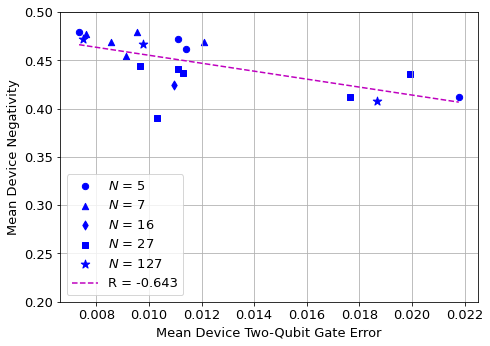

In [82]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(7, 5))
s = 40
ax.scatter(err_mean[:4], nmit_mean_list[:4], marker='o', color='b', s=s, label='$\it{N}$ = 5')
#ax.errorbar(err_mean[:4], nmit_mean_list[:4], nmit_std_list[:4], err_std[:4], marker='o', color='b', markersize=3, label='$\it{N}$ = 5', ls='')
ax.scatter(err_mean[4:9], nmit_mean_list[4:9], marker='^', color='b', s=s, label='$\it{N}$ = 7')
ax.scatter(err_mean[9], nmit_mean_list[9], marker='d', color='b', s=s, label='$\it{N}$ = 16')
ax.scatter(err_mean[10:16], nmit_mean_list[10:16], marker='s', color='b', s=s, label='$\it{N}$ = 27')
ax.scatter(err_mean[16:19], nmit_mean_list[16:19], marker='*', color='b', s=s*2, label='$\it{N}$ = 127')
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'R = {corr1:.3f}')

ax.set_ylim(0.2, 0.5)

ax.set_ylabel('Mean Device Negativity')
ax.set_xlabel('Mean Device Two-Qubit Gate Error')
#ax.set_title('QREM')

ax.legend()
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation4', dpi=300)